In [1]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend

from compare_variance_residual.residual import residual_method
from compare_variance_residual.simulation import generate_dataset, save_scores
from compare_variance_residual.variance_partitioning import variance_partitioning

In [2]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying noise")
    os.makedirs(path, exist_ok=True)
    return path

In [3]:
def get_experiments(alphas, cv, n_targets):
    path = get_path(alphas, cv, n_targets)
    experiments = []
    for file in os.listdir(path):
        if file.endswith(".csv"):
            variable = file.split("_")[1].split(".csv")[0]
            # parse variable
            noise = float(variable)
            experiments.append(noise)
    return experiments

# Save scores for varying noise levels

In [5]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)
plt.style.use('nord-light-talk')

In [6]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
scalars = [1 / 3, 1 / 3, 1 / 3]

cv = 10
alphas = np.logspace(-5, 5, 10)
path = get_path(alphas, cv, n_targets)

In [9]:
nstep = 11
noise_levels = np.linspace(0, 1, nstep)
noise_levels

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [10]:
save_scores(path, noise_levels, d_list, scalars, n_targets, n_samples, cv, alphas)

0.0
skipping, already exists
0.1
skipping, already exists
0.2
skipping, already exists
0.30000000000000004
data generated
variance partitioning done
   x1_score  x2_score  vp_joint_score  vp_shared_score  vp_x1_unique_score  \
0  0.387284  0.396526        0.658230         0.125580            0.261705   
1  0.423429  0.462979        0.672119         0.214290            0.209139   
2  0.547224  0.588325        0.815820         0.319729            0.227495   
3  0.446707  0.529417        0.721508         0.254616            0.192091   
4  0.394629  0.446523        0.712315         0.128837            0.265792   

   vp_x2_unique_score  
0            0.270946  
1            0.248690  
2            0.268596  
3            0.274801  
4            0.317686  
residual method done
0.4
data generated
variance partitioning done
   x1_score  x2_score  vp_joint_score  vp_shared_score  vp_x1_unique_score  \
0  0.299597  0.308292        0.531459         0.076429            0.223168   
1  0.362636  0.

# Plot scores

In [11]:
vp = pd.DataFrame()
rm = pd.DataFrame()

all_levels = get_experiments(alphas, cv, n_targets)
print(all_levels)
for i, noise_level in enumerate(all_levels):
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{noise_level}.csv"))
    vp_x1_unique_predicted = scores['vp_x1_unique_score']
    vp_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'vp_x1_unique_score': vp_x1_unique_predicted,
    }, index=range(len(vp_x1_unique_predicted)))

    rm_x1_unique_score = scores['rm_x1_unique_score']
    rm_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'rm_x1_unique_score': rm_x1_unique_score,
    }, index=range(len(vp_x1_unique_predicted)))

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
vp.head()

[0.0, 0.05, 0.2, 0.4, 0.9, 0.25, 0.5, 0.15000000000000002, 1.0, 0.8, 0.1, 0.6000000000000001, 0.30000000000000004, 0.7000000000000001]


,noise_target,vp_x1_unique_score
0,0.0,0.351996
1,0.0,0.334528
2,0.0,0.270543
3,0.0,0.323304
4,0.0,0.438242


Text(0, 0.5, '$R^2$')

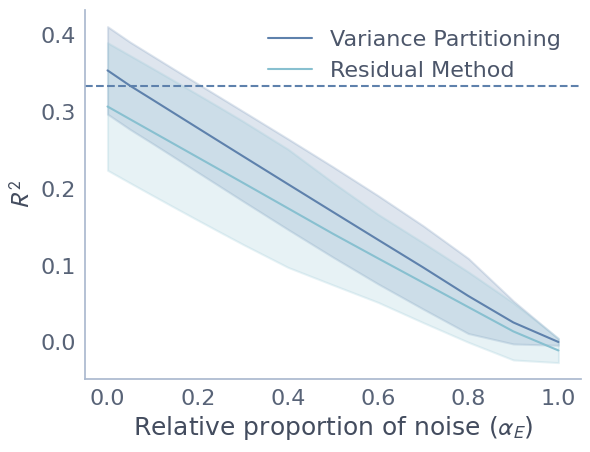

In [13]:
sns.lineplot(data=vp, x='noise_target', y='vp_x1_unique_score', label='Variance Partitioning', errorbar='sd')
sns.lineplot(data=rm, x='noise_target', y='rm_x1_unique_score', label='Residual Method', errorbar='sd')
plt.axhline(scalars[1], linestyle='--', label='true unique variance')
plt.xlabel(r"Relative proportion of noise ($\alpha_E$)")
plt.ylabel(r"$R^2$")